In [58]:
import cv2
import numpy as np

def calculate_deviation(image):
    """Calculates the deviation of a line from the center of the image."""
    
    height, width = image.shape[:2]
    middle_row = int (height/2)  # Use the last 20 rows of the image

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        roi = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to get binary image
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY) 

    row = binary[middle_row, :]  # Select middle row of the image
    
    # Find white pixels (line)
    white_pixels = np.where(binary > 0)

    if len(white_pixels) == 0:
        return None  # No line detected

    # Compute line center
    x_line = np.mean(white_pixels)  # Mean of x-coordinates of line pixels

    # Compute deviation
    x_center = width / 2
    deviation = x_line - x_center
    normalized_deviation = deviation / (width / 2)  # Normalize to range [-1,1]

    return normalized_deviation


In [56]:
import os

def process_images_in_folder(folder):
    """Reads all images in a folder and applies the deviation calculation."""
    
    deviations = np.zeros(1)
    norm_dev = np.zeros(1) 
    
    if not os.path.exists(folder):
        print("Folder does not exist.")
        return
    
    # Get all image files
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    norm_dev = np.zeros(len(image_files))
    if not image_files:
        print("No images found in the folder.")
        return

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

        if image is None:
            print(f"Failed to read {filename}")
            continue

        norm_dev[i] = calculate_deviation(image)
        
        #print(f"{filename}: Normalized = {norm_dev[i]:.2f}")
        
    return norm_dev


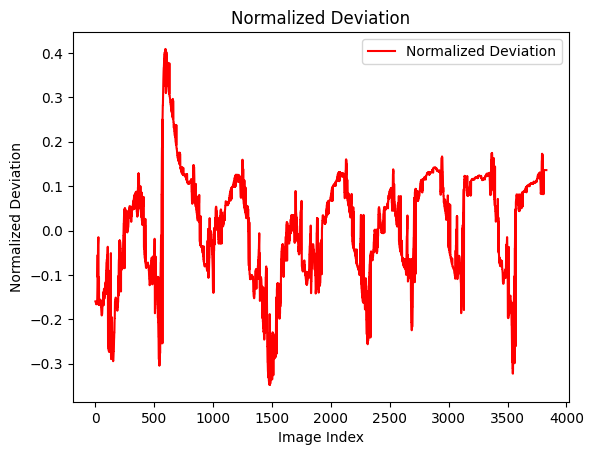

In [59]:
import matplotlib.pyplot as plt

folder_name = "images2"  # Change to your folder path
norm_dev = process_images_in_folder(folder_name)

# Create a new figure for the normalized deviation plot
plt.figure()
plt.plot(norm_dev, linestyle='-', color='r', label="Normalized Deviation")
plt.xlabel("Image Index")
plt.ylabel("Normalized Deviation")
plt.title("Normalized Deviation")
plt.legend()
plt.show()

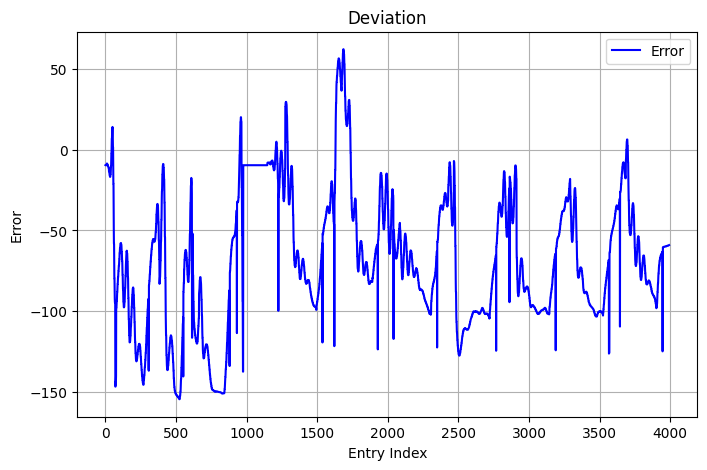

In [31]:
import csv
import matplotlib.pyplot as plt
import numpy as np

def plot_data(filename):
    """Loads the data from a CSV file and plots it."""
    data = []
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row:  # Ensure non-empty rows
                data.append(float(row[0]))  # Convert each row's first value to float

    plt.figure(figsize=(8, 5))
    plt.plot(data, linestyle='-', color='b', label="Error")
    plt.xlabel("Entry Index")
    plt.ylabel("Error")
    plt.title("Deviation")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_data("error.csv")

In [ ]:
def evaluate_performance(image):
    """Reads all images in a folder and applies the deviation calculation."""
    
    deviations = np.zeros(1)
    norm_dev = np.zeros(1) 
    
    if not os.path.exists(folder):
        print("Folder does not exist.")
        return
    
    # Get all image files
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    deviations = np.zeros(len(image_files))
    norm_dev = np.zeros(len(image_files))
    if not image_files:
        print("No images found in the folder.")
        return

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

        if image is None:
            print(f"Failed to read {filename}")
            continue

        deviations[i], norm_dev[i] = calculate_deviation(image)
        
        print(f"{filename}: Deviation = {deviations[i]:.2f} px, Normalized = {norm_dev[i]:.2f}")
        
    return deviations, norm_dev

In [1]:
import cv2
import numpy as np
import os
import csv

def detect_centerline(image):
    """Detects the centerline of a white line in a black background and returns (x, y) points."""
    height, width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Region of interest (ROI) is the top half of the image as the robot only moves forward
    roi = gray[:int(height/2)+1, :] 
    
    # Threshold to isolate the white line
    _, binary = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)
    line_center = []
    for i in range(0, int(height/2) , 11):
       # Find white pixels (line)
        row = binary[i, :]
        white_pixels = np.where(row > 0)
        try:
            center_y = int (np.mean(white_pixels))
        except: 
            continue
        if len(white_pixels) > 0:
            # Compute line center
            line_center.append((i, center_y ))
    return line_center

def calculate_angle(centerline, image_width):
    """Calculates the angle of the white line with respect to the vertical axis."""
    
    if len(centerline) < 2:
        return None  # Not enough points to calculate angle

    # Fit a line using linear regression
    x_coords = np.array([p[0] for p in centerline])
    y_coords = np.array([p[1] for p in centerline])
    
    # Fit a line: y = mx + b
    m, b = np.polyfit(x_coords, y_coords, 1)  # Slope and intercept

    # Calculate angle from vertical axis
    angle_rad = np.arctan(m)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

def process_images(folder, output_csv="line_labels.csv"):
    """Processes all images in a folder and saves centerline points + angle."""
    
    if not os.path.exists(folder):
        print("Folder does not exist.")
        return

    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print("No images found.")
        return

    with open(output_csv, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["image_name", "distance", "angle_deg"])  # Header

        for filename in image_files:
            image_path = os.path.join(folder, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to read {filename}")
                continue

            centerline = detect_centerline(image)

            if len(centerline)> 1:
                image_width = image.shape[1]  # Get image width
                angle = calculate_angle(centerline, image_width)
                writer.writerow([filename, 160 - centerline[-1][1], round(angle, 2) if angle is not None else "N/A"])

                # Optional: Draw centerline + angle display
                for x, y in centerline:
                    cv2.circle(image, (y, x), 2, (0, 255, 0), -1)  # Green dots

                # Display angle info
                text = f"Angle: {round(angle, 2)}"
                cv2.putText(image, text, (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                text = f"Distance: {round(160 - centerline[-1][1], 2)}"
                cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                cv2.imshow("Detected Line & Angle", image)
                cv2.waitKey()

    cv2.destroyAllWindows()
    print(f"Labels & angles saved to {output_csv}")

In [2]:
process_images("im", output_csv="line_labels.csv")  # Change folder path and output CSV file name if needed

Labels & angles saved to line_labels.csv
